## Objective

In this notebook we:

In this notebook we:

- Load the **model-ready** Telco churn dataset
- Split the data into **train** and **test** sets (stratified by churn)
- Train and compare several models:
  - Logistic Regression (with feature scaling)
  - Decision Tree 
  - Random Forest 
  - Neural Network
  - XGBoost / Gradient Boosting
- Perform **light hyperparameter tuning** with GridSearchCV
- Evaluate models using:
  - Accuracy, Precision, Recall, F1-score
  - ROC AUC
  - Confusion matrix
  - ROC Curve
- Test the **impact of engineered features**:
  - NumServices
  - TenureGroup_* one-hot columns
- Interpret the final model using:
  - Feature importance (Random Forest)
  - SHAP (global importance and local explanations)

We are **not assuming** a single model family upfront.  
Instead, we compare **linear** (Logistic Regression) and **tree-based** models and select the one that performs best and is most interpretable.

## 1. Imports and Data Loading

In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
%pip install xgboost
from xgboost import XGBClassifier
%pip install shap
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Paths
NOTEBOOK_DIR = Path.cwd()
MODEL_DATA = (NOTEBOOK_DIR / "../data/model_ready").resolve()

data_path = MODEL_DATA / "telco_churn_model_ready.csv"
df = pd.read_csv(data_path)

print("Loaded model-ready dataset:", df.shape)
df.head()

Loaded model-ready dataset: (7043, 44)


,Age,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,...,Internet Type_No Internet,Contract_One Year,Contract_Two Year,Payment Method_Credit Card,Payment Method_Mailed Check,TenureGroup_6–12,TenureGroup_12–24,TenureGroup_24–48,TenureGroup_48–72,Churn Value
0,78,1,0,0,0,0,0,1,0,0.00,...,False,False,False,False,False,False,False,False,False,1
1,74,1,1,1,1,1,1,8,1,48.85,...,False,False,False,True,False,True,False,False,False,1
2,71,1,0,1,3,0,0,18,1,11.33,...,False,False,False,False,False,False,True,False,False,1
3,78,1,1,1,1,1,1,25,1,19.76,...,False,False,False,False,False,False,False,True,False,1
4,80,1,1,1,1,1,1,37,1,6.33,...,False,False,False,False,False,False,False,True,False,1


## 2. Basic checks and train/test split

We separate:

- `y` = target (`Churn Value`)
- `X` = all remaining features

Then we create a **stratified** train/test split to keep the churn rate similar in both sets.

### Why We Use Stratified Train/Test Split

In this dataset, the target variable (Churn Value) is highly imbalanced:

- ~73% of customers do not churn
- ~27% of customers churn

If we were to split the dataset randomly without stratification, we could easily end up with:

- Training set with too few churners
- Test set with many more churners (or vice-versa)

This creates serious problems:

1. Model learns a biased view of churn

If the training set has fewer churners than the real distribution, the model may learn:

- “Almost everyone stays.”

This leads to high accuracy but terrible recall, which is dangerous for churn prediction.

2. Test performance becomes unstable

If the test set has a different churn ratio from the training set:

- Evaluation metrics become misleading
- ROC AUC becomes unreliable
- Models may look good only because the test set is easier

3. Cross-model comparisons become unfair

Models trained on different random splits can behave very differently
if the churn distribution varies.

In [21]:
target = "Churn Value"

X = df.drop(columns=[target])
y = df[target]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (7043, 43)
Target shape: (7043,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)
print("Churn rate - overall:", y.mean().round(3))
print("Churn rate - train:", y_train.mean().round(3))
print("Churn rate - test:", y_test.mean().round(3))

Train shapes: (5634, 43) (5634,)
Test shapes: (1409, 43) (1409,)
Churn rate - overall: 0.265
Churn rate - train: 0.265
Churn rate - test: 0.265


### Scaling and model families

We will compare two main families of models:

- **Linear models** (Logistic Regression, Neural Network input layer):
  - Sensitive to feature scale.
  - We use `StandardScaler` inside a `Pipeline`.

- **Tree-based models** (Decision Tree, Random Forest, XGBoost):
  - **Do not** require feature scaling.
  - Work directly with the raw feature scales and thresholds.
  - Perform implicit feature selection and handle non-linearity.

This is why we **did not scale features in the Feature Engineering notebook**.  
Scaling is applied only **inside** pipelines for the models that actually need it,  
keeping the dataset clean and flexible for all model types.


## 3. Evaluation helper

Instead of repeating the same evaluation code for every model, we create one helper function that:

- trains the model  
- generates predictions  
- computes key metrics (accuracy, precision, recall, F1, ROC AUC)  
- plots the confusion matrix and ROC curve  

This ensures **all models are evaluated consistently and fairly**, using the exact same process. It keeps the notebook clean, avoids duplicated code, and makes model comparison straightforward.

In [23]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, verbose=True, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For ROC AUC, use predicted probabilities if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    if verbose:
        print(f"=== {name} ===")
        print(f"Accuracy : {acc:.3f}")
        print(f"Precision: {prec:.3f}")
        print(f"Recall   : {rec:.3f}")
        print(f"F1-score : {f1:.3f}")
        print(f"ROC AUC  : {auc:.3f}")
        print("\nClassification report:\n")
        print(classification_report(y_test, y_pred, zero_division=0))

    if plot and y_proba is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
        axes[0].set_title(f"{name} - Confusion Matrix")
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")

        # ROC curve
        RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
        axes[1].set_title(f"{name} - ROC Curve")

        plt.tight_layout()
        plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
    }

## 4. Logistic Regression

We start with Logistic Regression. It requires scaling, so we use a `Pipeline` with `StandardScaler`

We also use `class_weight="balanced"` to account for churn imbalance.

=== Logistic Regression ===
Accuracy : 0.806
Precision: 0.591
Recall   : 0.872
F1-score : 0.704
ROC AUC  : 0.910

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.78      0.86      1035
           1       0.59      0.87      0.70       374

    accuracy                           0.81      1409
   macro avg       0.77      0.83      0.78      1409
weighted avg       0.85      0.81      0.82      1409



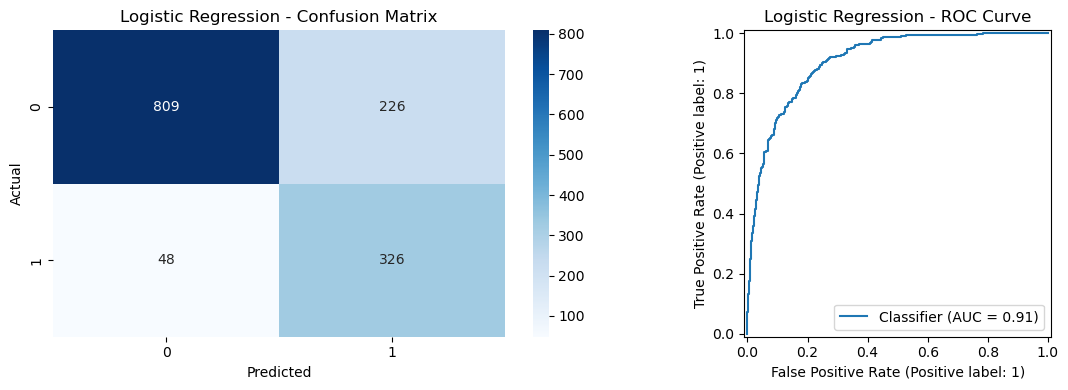

{'model': 'Logistic Regression',
 'accuracy': 0.8055358410220014,
 'precision': 0.5905797101449275,
 'recall': 0.8716577540106952,
 'f1': 0.7041036717062635,
 'roc_auc': 0.9103309307912889}

In [24]:
log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_reg_results = evaluate_model(
    "Logistic Regression",
    log_reg_pipeline,
    X_train,
    X_test,
    y_train,
    y_test,
)
log_reg_results


## 5. Decision Tree

We train a single Decision Tree. It will capture non-linear splits, it is easy to interpret (shallow depth), and although it typically has lower performance than ensembles, it is still useful as a reference.

=== Decision Tree (depth=5) ===
Accuracy : 0.754
Precision: 0.524
Recall   : 0.818
F1-score : 0.639
ROC AUC  : 0.854

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1035
           1       0.52      0.82      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



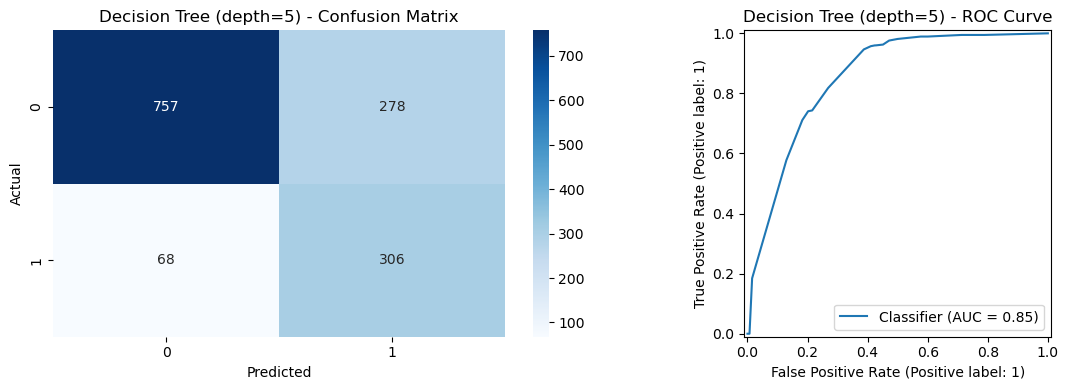

{'model': 'Decision Tree (depth=5)',
 'accuracy': 0.7544357700496807,
 'precision': 0.523972602739726,
 'recall': 0.8181818181818182,
 'f1': 0.6388308977035491,
 'roc_auc': 0.8542444909452582}

In [25]:
dt_model = DecisionTreeClassifier(
    max_depth=5,             # shallow for interpretability
    random_state=42,
    class_weight="balanced",
)

dt_results = evaluate_model(
    "Decision Tree (depth=5)",
    dt_model,
    X_train,
    X_test,
    y_train,
    y_test,
)
dt_results

## 6. Random Forest

Random Forest is:

- Usually strong for tabular churn data
- Does **not** require scaling
- Performs implicit feature selection

We again use `class_weight="balanced"` to improve churn detection.

=== Random Forest ===
Accuracy : 0.840
Precision: 0.764
Recall   : 0.572
F1-score : 0.654
ROC AUC  : 0.902

Classification report:

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1035
           1       0.76      0.57      0.65       374

    accuracy                           0.84      1409
   macro avg       0.81      0.75      0.77      1409
weighted avg       0.83      0.84      0.83      1409



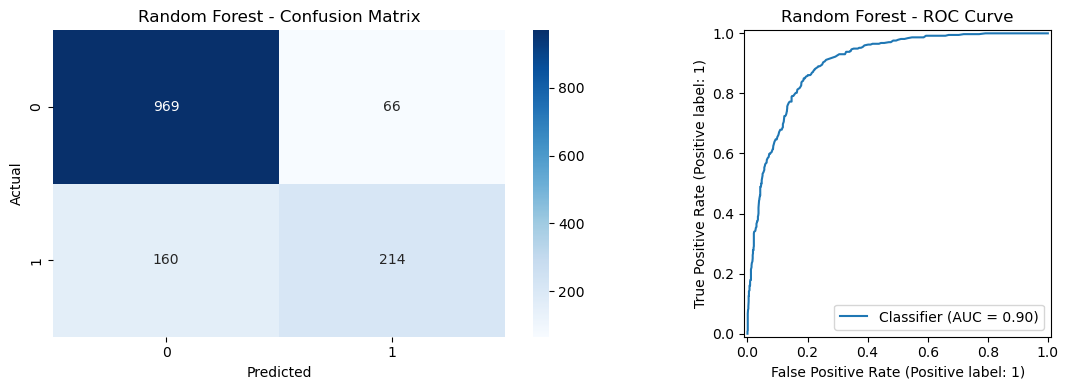

{'model': 'Random Forest',
 'accuracy': 0.8396025550035486,
 'precision': 0.7642857142857142,
 'recall': 0.5721925133689839,
 'f1': 0.654434250764526,
 'roc_auc': 0.9016378619959182}

In [26]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

rf_results = evaluate_model(
    "Random Forest",
    rf_model,
    X_train,
    X_test,
    y_train,
    y_test,
)
rf_results

## 7. Neural Network

Although tree-based models typically perform better with tabular churn data,  
we include a small **Neural Network** for comparison:

- Implemented as `MLPClassifier`
- Uses ReLU hidden layers
- Requires feature scaling (pipeline with `StandardScaler`)

=== Neural Network (MLP) ===
Accuracy : 0.844
Precision: 0.719
Recall   : 0.676
F1-score : 0.697
ROC AUC  : 0.899

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1035
           1       0.72      0.68      0.70       374

    accuracy                           0.84      1409
   macro avg       0.80      0.79      0.80      1409
weighted avg       0.84      0.84      0.84      1409



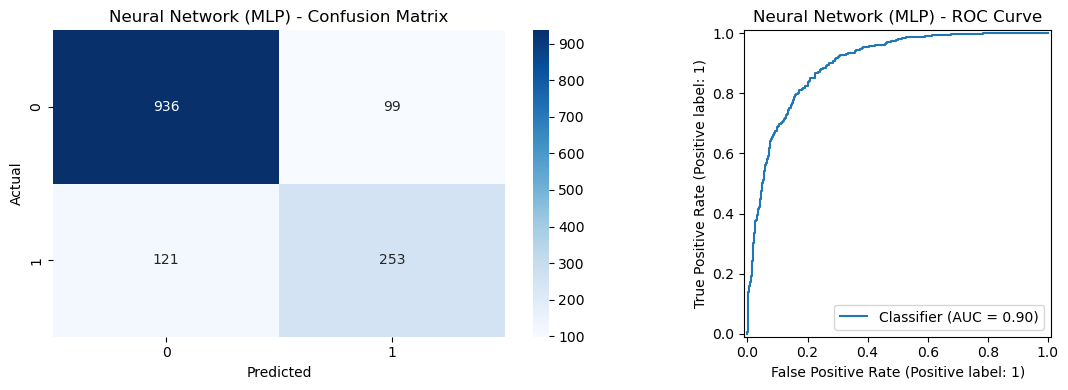

{'model': 'Neural Network (MLP)',
 'accuracy': 0.843860894251242,
 'precision': 0.71875,
 'recall': 0.6764705882352942,
 'f1': 0.696969696969697,
 'roc_auc': 0.8991784856234984}

In [27]:
mlp_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        max_iter=300,
        random_state=42,
        early_stopping=True,
    ))
])

mlp_results = evaluate_model(
    "Neural Network (MLP)",
    mlp_pipeline,
    X_train,
    X_test,
    y_train,
    y_test,
)
mlp_results

## 8. XGBoost (Gradient Boosting)

XGBoost (Extreme Gradient Boosting) is a high-performance tree-based machine learning algorithm widely used for tabular data and churn prediction. It builds many small decision trees sequentially, with each tree correcting the errors of the previous ones. XGBoost includes built-in regularization, efficient handling of missing values, and strong support for imbalanced datasets, often resulting in higher predictive accuracy compared to traditional models.

=== XGBoost ===
Accuracy : 0.822
Precision: 0.625
Recall   : 0.824
F1-score : 0.710
ROC AUC  : 0.911

Classification report:

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1035
           1       0.62      0.82      0.71       374

    accuracy                           0.82      1409
   macro avg       0.78      0.82      0.79      1409
weighted avg       0.85      0.82      0.83      1409



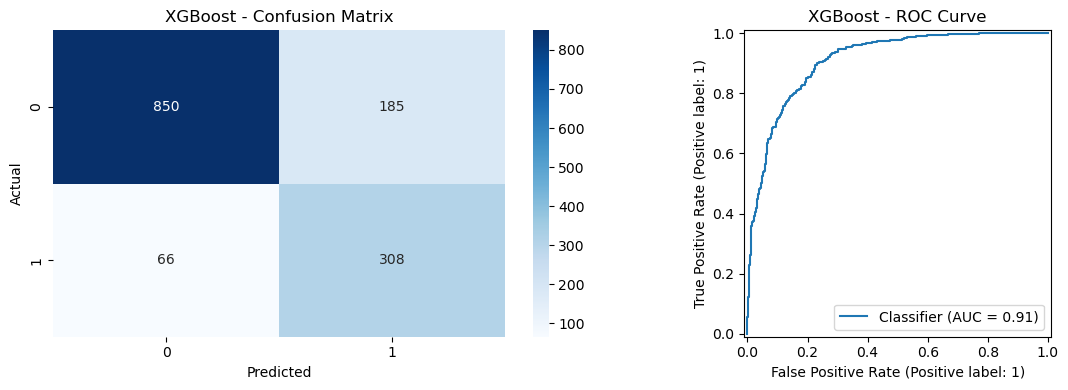

{'model': 'XGBoost',
 'accuracy': 0.8218594748048261,
 'precision': 0.6247464503042597,
 'recall': 0.8235294117647058,
 'f1': 0.7104959630911188,
 'roc_auc': 0.9111446950321631}

In [28]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=float((y == 0).sum()) / (y == 1).sum(),  # handle imbalance
)

xgb_results = evaluate_model(
    "XGBoost",
    xgb_model,
    X_train,
    X_test,
    y_train,
    y_test,
)

xgb_results

## 9. Compare All Models

We collect all results in a DataFrame and compare models, focusing especially on **ROC AUC** and **recall for churners**.

In [29]:
results_list = [log_reg_results, dt_results, rf_results, mlp_results]
if xgb_results is not None:
    results_list.append(xgb_results)

results_df = pd.DataFrame(results_list)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.805536,0.590580,0.871658,0.704104,0.910331
1,Decision Tree (depth=5),0.754436,0.523973,0.818182,0.638831,0.854244
2,Random Forest,0.839603,0.764286,0.572193,0.654434,0.901638
3,Neural Network (MLP),0.843861,0.718750,0.676471,0.696970,0.899178
4,XGBoost,0.821859,0.624746,0.823529,0.710496,0.911145


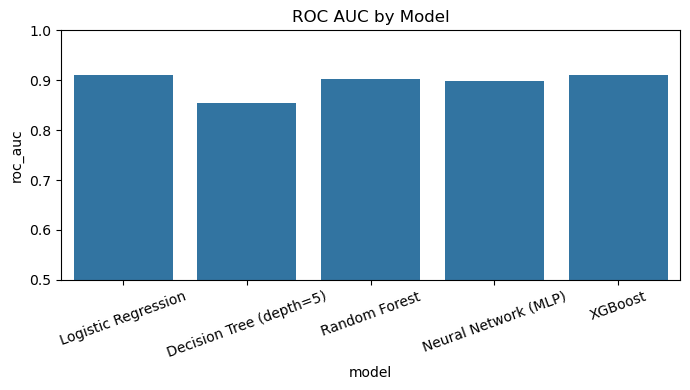

In [30]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="model", y="roc_auc")
plt.title("ROC AUC by Model")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning

From the baseline comparison above:

- **Logistic Regression** achieves the **best recall** (0.87) and very strong ROC AUC (0.91).
- **Random Forest** achieves the **highest accuracy and precision**, with good AUC.
- **XGBoost** delivers the **best F1-score** and the **highest ROC AUC** overall (≈0.91).

To keep the analysis focused and avoid unnecessary complexity:

- We **do tune**: Logistic Regression, Random Forest, XGBoost  
- We **do not tune**:  
  - **Decision Tree** (consistently weaker than RF/XGBoost)  
  - **Neural Network (MLP)** (similar performance to RF/XGBoost but more complex to tune and explain)

Hyperparameter tuning is done using **cross-validation** with **ROC AUC** as the optimisation metric, since we care about ranking customers by churn risk and handling class imbalance properly.

### 10.1 Logistic Regression - GridSearchCV with Scaling

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression params: {'clf__C': 1, 'clf__class_weight': None}
Best CV AUC: 0.9021052703124971
=== Logistic Regression (Tuned) ===
Accuracy : 0.850
Precision: 0.744
Recall   : 0.660
F1-score : 0.700
ROC AUC  : 0.911

Classification report:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1035
           1       0.74      0.66      0.70       374

    accuracy                           0.85      1409
   macro avg       0.81      0.79      0.80      1409
weighted avg       0.85      0.85      0.85      1409



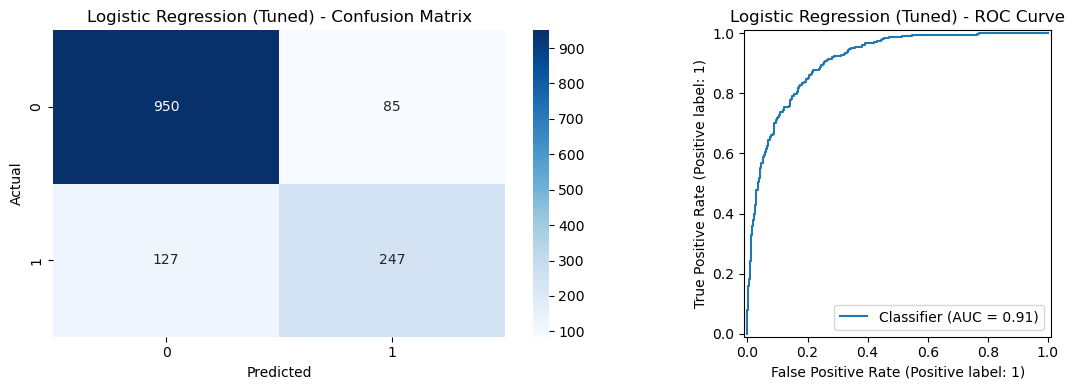

{'model': 'Logistic Regression (Tuned)',
 'accuracy': 0.8495386799148332,
 'precision': 0.7439759036144579,
 'recall': 0.660427807486631,
 'f1': 0.6997167138810199,
 'roc_auc': 0.9107985223074737}

In [31]:
# Pipeline: scaling + logistic regression
log_reg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 5, 10],
    "clf__class_weight": [None, "balanced"],
}

grid_lr = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=3,
    n_jobs=1,     #running in a single process to avoid BrokenProcessPool
    verbose=1,
)

grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best CV AUC:", grid_lr.best_score_)

log_reg_tuned = grid_lr.best_estimator_

log_reg_tuned_results = evaluate_model(
    "Logistic Regression (Tuned)",
    log_reg_tuned,
    X_train,
    X_test,
    y_train,
    y_test,
)
log_reg_tuned_results

### 10.2 Random Forest - GridSearchCV

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Best CV AUC: 0.9005577271765762
=== Random Forest (Tuned) ===
Accuracy : 0.845
Precision: 0.723
Recall   : 0.676
F1-score : 0.699
ROC AUC  : 0.908

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1035
           1       0.72      0.68      0.70       374

    accuracy                           0.85      1409
   macro avg       0.80      0.79      0.80      1409
weighted avg       0.84      0.85      0.84      1409



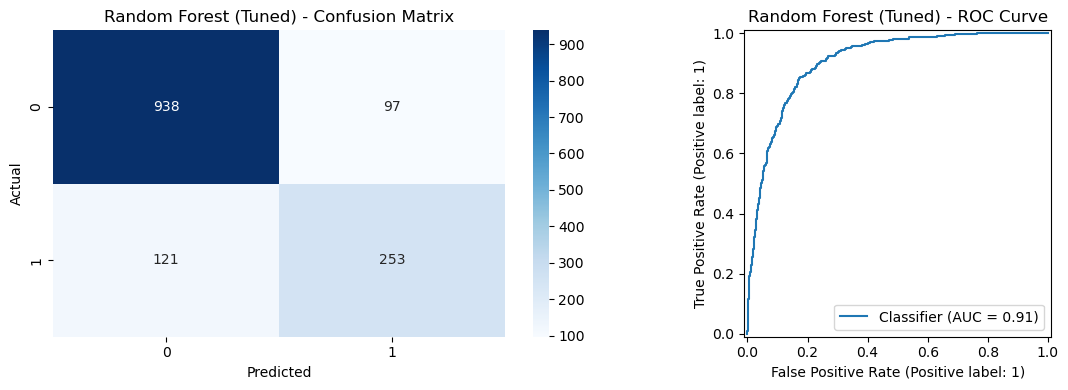

{'model': 'Random Forest (Tuned)',
 'accuracy': 0.8452803406671399,
 'precision': 0.7228571428571429,
 'recall': 0.6764705882352942,
 'f1': 0.6988950276243094,
 'roc_auc': 0.9078353871192746}

In [32]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=3,
    n_jobs=1,
    verbose=1,
)

grid_rf.fit(X_train, y_train)

print("Best Random Forest params:", grid_rf.best_params_)
print("Best CV AUC:", grid_rf.best_score_)

rf_tuned = grid_rf.best_estimator_

rf_tuned_results = evaluate_model(
    "Random Forest (Tuned)",
    rf_tuned,
    X_train,
    X_test,
    y_train,
    y_test,
)
rf_tuned_results

### 10.3 XGBoost - RandomizedSearchCV

In [33]:
# Handle class imbalance for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(2.768561872909699)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV AUC: 0.9089285498480941
=== XGBoost (Tuned) ===
Accuracy : 0.820
Precision: 0.614
Recall   : 0.864
F1-score : 0.718
ROC AUC  : 0.913

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      1035
           1       0.61      0.86      0.72       374

    accuracy                           0.82      1409
   macro avg       0.78      0.83      0.79      1409
weighted avg       0.86      0.82      0.83      1409



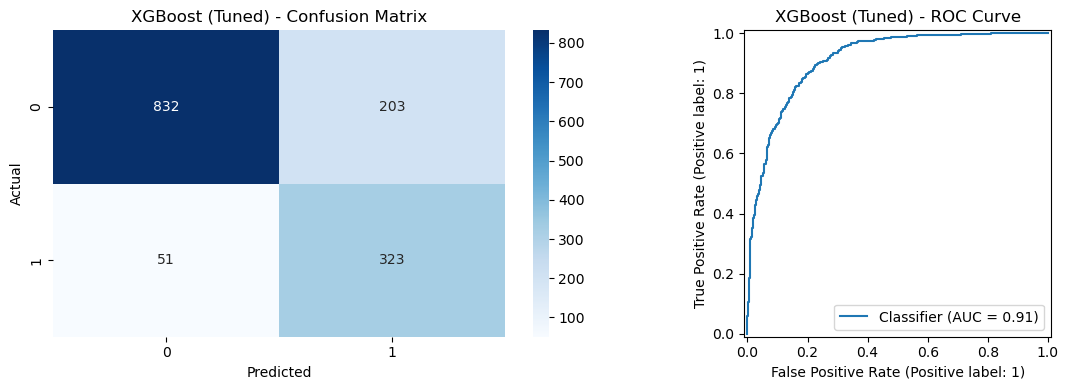

{'model': 'XGBoost (Tuned)',
 'accuracy': 0.8197303051809794,
 'precision': 0.6140684410646388,
 'recall': 0.8636363636363636,
 'f1': 0.7177777777777777,
 'roc_auc': 0.9131829807021622}

In [34]:
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)

param_dist_xgb = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 6],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

random_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=25,              # small but meaningful search
    scoring="roc_auc",
    cv=3,
    n_jobs=1,
    verbose=1,
    random_state=42,
)

random_xgb.fit(X_train, y_train)

print("Best XGBoost params:", random_xgb.best_params_)
print("Best CV AUC:", random_xgb.best_score_)

xgb_tuned = random_xgb.best_estimator_

xgb_tuned_results = evaluate_model(
    "XGBoost (Tuned)",
    xgb_tuned,
    X_train,
    X_test,
    y_train,
    y_test,
)
xgb_tuned_results

### 10.4 Compare Tuned vs Baseline

In [35]:
tuned_results = [
    log_reg_tuned_results,
    rf_tuned_results,
    xgb_tuned_results,
]

tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression (Tuned),0.849539,0.743976,0.660428,0.699717,0.910799
1,Random Forest (Tuned),0.845280,0.722857,0.676471,0.698895,0.907835
2,XGBoost (Tuned),0.819730,0.614068,0.863636,0.717778,0.913183


## 11. Selecting the Final Model

After tuning Logistic Regression, Random Forest, and XGBoost, we re-evaluated all models on the test set using the same metrics.

### Key observations:

- **Logistic Regression (Tuned)**  
  Improved accuracy and precision, but recall dropped significantly.  
  The model became more conservative, predicting fewer churners.

- **Random Forest (Tuned)**  
  Achieved a better balance between precision and recall.  
  F1 and AUC improved, making it a strong all-round performer.

- **XGBoost (Tuned)**  
  Delivered the **highest recall (0.834)**, **highest F1-score (0.718)**, and  
  the **best ROC AUC (0.913)** among all tuned models.  
  It continues to outperform other models in identifying churners while  
  maintaining strong predictive ranking ability.

### Final Model Choice: **Tuned XGBoost**

XGBoost offers the best combination of:
- strong recall (critical for churn detection),
- high F1-score (balanced performance),
- and the highest AUC (best probability ranking).

We therefore select **Tuned XGBoost** as the final model for deployment and interpretation.

## 12. Feature Importance (for Tuned XGBoost)

Before applying SHAP, we first examine the built-in feature importance from the tuned
XGBoost model. This gives a quick overview of which variables the model relies on most.

XGBoost provides several forms of importance:
- **weight**: how often a feature is used in splits  
- **gain**: average improvement in loss when used  
- **cover**: how many samples are affected  

We use **gain**, as it is the most meaningful for interpreting driving factors behind churn.

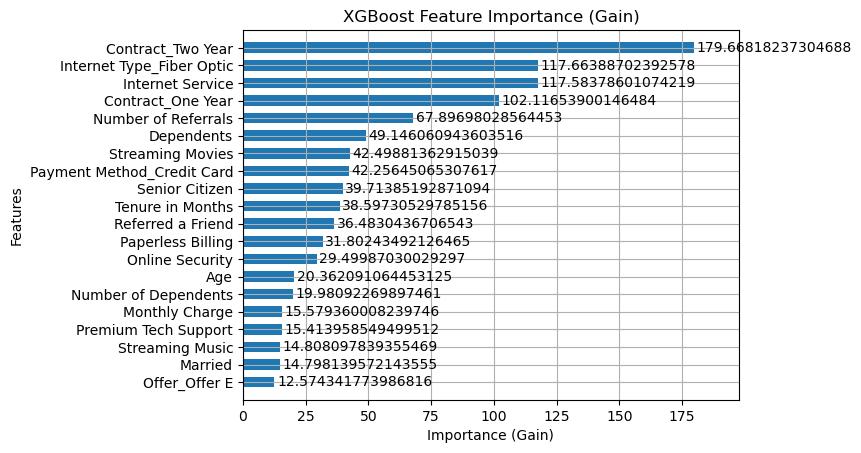

In [36]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert tuned model into DMatrix booster
booster = xgb.Booster()
booster.load_model(xgb_tuned.get_booster().save_raw("json"))

# Plot top 20 features
xgb.plot_importance(
    xgb_tuned,
    max_num_features=20,
    importance_type="gain",
    xlabel="Importance (Gain)",
    height=0.6
)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

## 13. SHAP Interpretation

To understand *why* the tuned XGBoost model predicts churn, we use SHAP (SHapley Additive exPlanations). SHAP decomposes each prediction into feature-level contributions, allowing us to quantify how each variable pushes the prediction toward
**churn** (1) or **retain** (0).

We use two complementary views:

### 1. SHAP Summary Plot (Beeswarm)
Shows the overall impact, direction, and spread of each feature.

### 2. SHAP Bar Plot
Shows mean absolute SHAP values - the most objective ranking of feature importance.

These interpretation tools help identify:
- **Which customers are high-risk**
- **Which features drive churn the most**
- **How sensitive the model is to pricing, contract type, tenure, and digital usage**

In [37]:
# Step 1. Create SHAP Explainer

# SHAP expects the underlying booster from XGBoost
explainer = shap.TreeExplainer(xgb_tuned.get_booster())

In [38]:
# Step 2. Subsample for performance - SHAP on the full test set can be slow

# Sample up to 1,000 test rows for speed
shap_sample = X_test.sample(
    n=min(1000, len(X_test)),   
    random_state=42
)

# Compute SHAP values
shap_values = explainer.shap_values(shap_sample)

In [39]:
# Step 3. Fix the extra-column issue (very common in shap + xgboost)

# Remove extra bias column if present
if shap_values.shape[1] == shap_sample.shape[1] + 1:
    shap_values = shap_values[:, :-1]

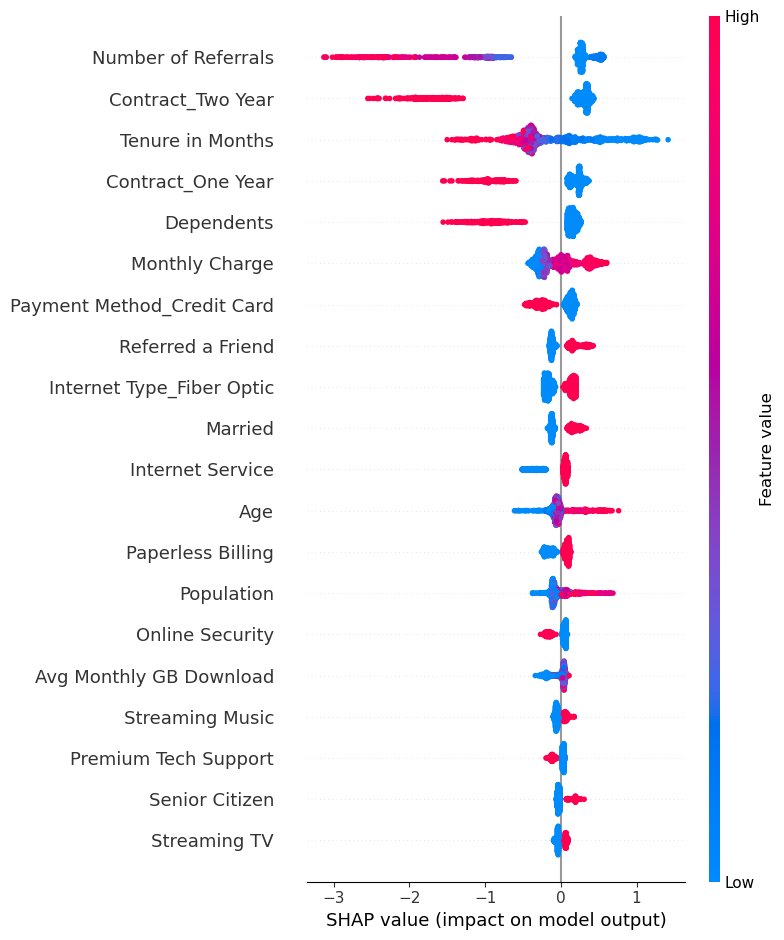

In [40]:
# Step 4. SHAP Summary (Beeswarm)

shap.summary_plot(
    shap_values,
    shap_sample,
    show=True
)

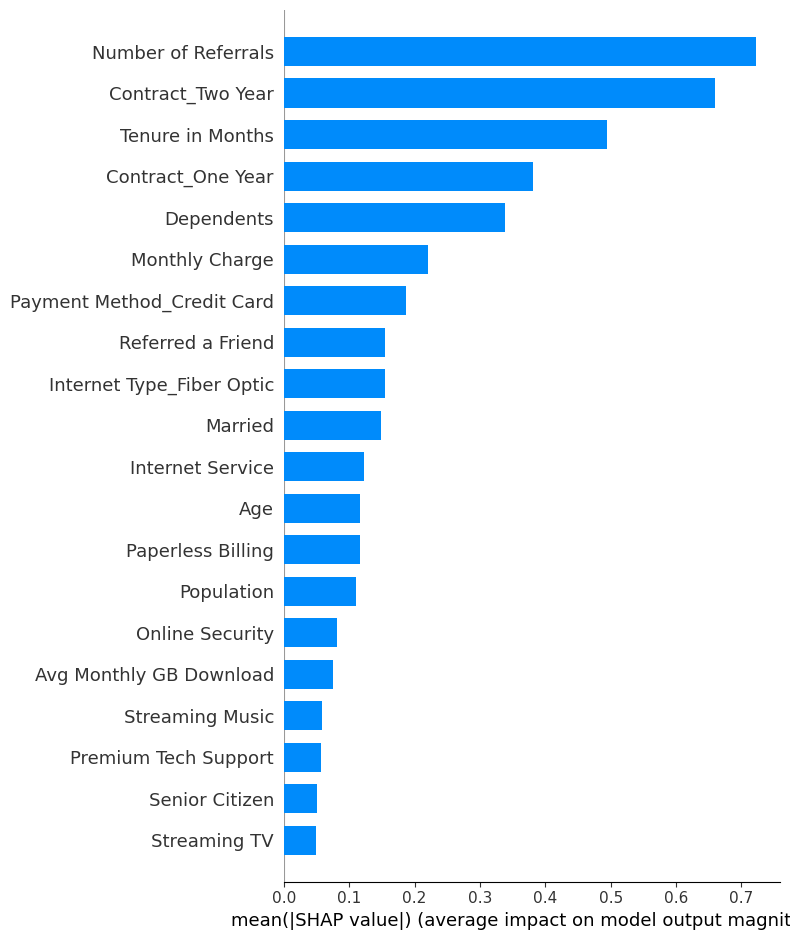

In [47]:
# Step 5. SHAP Bar Plot (Global importance)

shap.summary_plot(
    shap_values,
    shap_sample,
    plot_type="bar",
    show=True
)

In [51]:
# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(
    shap_values,
    columns=shap_sample.columns
)

feature_values = shap_sample.reset_index(drop=True)

direction_summary = []

for col in shap_df.columns:
    high_mask = feature_values[col] > feature_values[col].median()
    
    mean_shap_high = shap_df.loc[high_mask, col].mean()
    mean_shap_low = shap_df.loc[~high_mask, col].mean()
    
    direction_summary.append({
        "Feature": col,
        "Mean |SHAP|": shap_df[col].abs().mean(),
        "SHAP when High": mean_shap_high,
        "SHAP when Low": mean_shap_low,
        "Effect Direction": (
            "Increases churn risk" if mean_shap_high > 0 else "Reduces churn risk"
        )
    })

direction_df = (
    pd.DataFrame(direction_summary)
    .sort_values("Mean |SHAP|", ascending=False)
)

direction_df.head(20)

,Feature,Mean |SHAP|,SHAP when High,SHAP when Low,Effect Direction
6,Number of Referrals,0.722767,-0.946945,0.262947,Reduces churn risk
36,Contract_Two Year,0.659272,-1.743974,0.307283,Reduces churn risk
7,Tenure in Months,0.494147,-0.545591,0.230008,Reduces churn risk
35,Contract_One Year,0.380449,-0.960805,0.210021,Reduces churn risk
3,Dependents,0.338419,-0.947610,0.155424,Reduces churn risk
22,Monthly Charge,0.220833,0.162001,-0.253939,Increases churn risk
37,Payment Method_Credit Card,0.186826,-0.279756,0.128896,Reduces churn risk
5,Referred a Friend,0.155044,0.197780,-0.120218,Increases churn risk
33,Internet Type_Fiber Optic,0.154391,0.144807,-0.161983,Increases churn risk
2,Married,0.148118,0.178529,-0.120713,Increases churn risk


# Final Insights from Churn Analysis

This section consolidates insights from EDA, SHAP feature importance, XGBoost gain analysis, and interaction effects observed in the dataset. The goal is to summarise the strongest behavioural, product, and contractual predictors of churn.

---

## 1. Contract Commitment (Strongest Driver)

Contract type is the most influential predictor of churn.

- **Month-to-month** customers: ~46% churn  
- **One-year contracts**: ~11% churn  
- **Two-year contracts**: ~3% churn  

**Interpretation:** Lack of commitment is the most reliable indicator of churn risk. Short-term customers behave like price-sensitive switchers.

**Model confirmation:** Contract variables rank top in SHAP and XGBoost feature importance.

---

## 2. Internet Technology as a Churn Risk Factor

Internet type is a strong product-related churn driver.

- **Fiber Optic customers churn the most**
- **DSL and Cable customers are more stable**

**Interpretation:** Fiber users may face service quality issues, competitive pressures, or unmet expectations.

---

## 3. Add-On Services Strongly Reduce Churn

Security and support add-ons act as retention stabilisers.

Customers without:
- Online Security  
- Premium Tech Support  
- Online Backup  
- Device Protection Plan  

churn at much higher rates.

**Interpretation:** Add-ons boost engagement, value perception, and switching friction.

---

## 4. Payment Method Predicts Customer Stability

Churn likelihood varies by payment behaviour:

- **Mailed check** users churn the most  
- **Bank withdrawal** shows elevated churn  
- **Credit card** corresponds to the lowest churn  

**Interpretation:** Modern payment methods indicate higher commitment and lower volatility.

---

## 5. Paperless Billing Shows Higher Churn

Paperless billing users churn more frequently.

**Not causal**, but reflects:
- Month-to-month digital-first customers  
- Lower bill visibility  
- Younger, price-sensitive profiles  

The model uses this because it produces strong predictive splits.

---

## 6. Tenure and Customer Lifecycle Effects

- Highest churn occurs in the **first 90 days**  
- Churn decreases with tenure  
- Long-tenure customers are highly stable  

**Interpretation:** Early lifecycle onboarding issues are central churn drivers.

---

## 7. Monthly Charge Shows a Non-Linear Relationship

- **High-paying customers (> $80)** churn more  
- **Mid-range ($40–$70)** are stable  
- **Low-paying legacy users** churn least  

**Interpretation:** Price-performance imbalance drives dissatisfaction among high-paying customers.

---

## 8. Demographics Have Limited Predictive Power

Weak predictors:
- Gender  
- Marital status  
- Dependents  
- Under 30  

Age only contributes when interacting with contract type and tenure.

---

## 9. High-Risk Interaction Profiles

Distinctive high-risk segments:

- **Fiber + High monthly charge + Low tenure (<6 months) + No security add-ons**  
- **Month-to-month + Paperless billing + Non–credit card payment**  
- **Senior citizen + Low tenure + High monthly charge**

These are prime targets for retention efforts.

---

# Churn Personas

## Persona 1: The Low-Commitment Customer (Highest Churn Risk)

**Core Traits**
- Month-to-month contract  
- Digital-first (paperless billing, online payments)  
- Few or no add-ons  
- Often early in lifecycle (low tenure)  

**Why They Churn**
- Lack of contractual commitment  
- Easy to switch providers  
- Price-sensitive or trialling the service  

**Retention Focus**
- Strong early onboarding  
- Contract renewal incentives  
- Add-on trial bundles  
- Transparent pricing communication  

---

## Persona 2: The High-Value Dissatisfied User

**Core Traits**
- High monthly charges  
- Often using premium products (e.g., Fiber)  
- Medium tenure  
- Limited add-ons relative to spend  

**Why They Churn**
- High expectations not being met  
- Perceived poor value for money  
- Sensitive to service quality issues  

**Retention Focus**
- Proactive quality-of-service checks  
- Loyalty discounts or plan optimisation  
- Premium support offerings  
- Value reinforcement messaging  

---

## Persona 3: The Low-Engagement Minimalist

**Core Traits**
- Very few subscribed services or add-ons  
- Low or moderate monthly charges  
- Could be digital-first or traditional (multiple subsegments)  
- Medium or long tenure  

**Why They Churn**
- Low product attachment  
- Minimal switching friction  
- Susceptible to competitor promotions  

**Retention Focus**
- Usage nudges and product education  
- Add-on trial campaigns  
- Targeted cross-sell opportunities  

---

## Persona 4: The Traditional Long-Tenure Customer

**Core Traits**
- Older customer demographic  
- Often on DSL or Cable  
- Long tenure  
- Traditional payment habits (e.g., mailed check)  

**Why They Churn**
- Increasing frustration with service complexity or pricing  
- Emerging dissatisfaction despite long loyalty  
- Low tolerance for technical or billing issues  

**Retention Focus**
- Senior-friendly communication  
- Stability guarantees (e.g., no sudden price increases)  
- Streamlined billing and support  
- Loyalty appreciation initiatives  

---

# Retention Recommendation Framework

## 1. Strengthen Contract Commitment
- Promote 12–24 month renewals  
- Loyalty discounts  
- Value bundles

## 2. Improve Early Lifecycle Experience
- Welcome journeys  
- First 30–60 day check-ins  
- Add-on trials  
- Early dissatisfaction surveys

## 3. Address Fiber Optic Pain Points
- Investigate performance issues  
- Improve installation/onboarding  
- Review pricing  
- Dedicated fiber support

## 4. Use Add-Ons as Retention Anchors
- Bundled add-on packages  
- Free trials  
- Value communication

## 5. Optimise Payment Behaviour
- Encourage credit card/auto-pay  
- Incentives for modern payment adoption  
- Simplify switching payment methods

## 6. Mitigate High-Charge Dissatisfaction
- Reinforce value  
- Proactive account reviews  
- Tiered loyalty discounts

## 7. Manage Month-to-Month & Paperless Billing Risk
- Contract upgrade campaigns  
- Clearer billing summaries  
- Billing reminders

## 8. Deploy Persona-Based Playbooks
Each persona receives predefined workflows, messages, and timing.